In [1]:
import pandas as pd

# Load the main dataset
data = pd.read_csv("/content/GDSC2-dataset.csv")

# Show a few rows
data.head()


,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,343,15946310,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046.0,Y,0.0001,0.1,-1.463887,0.930220,0.089052,0.433123
1,GDSC2,343,15946548,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046.0,Y,0.0001,0.1,-4.869455,0.614970,0.111351,-1.421100
2,GDSC2,343,15946830,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046.0,Y,0.0001,0.1,-3.360586,0.791072,0.142855,-0.599569
3,GDSC2,343,15947087,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046.0,Y,0.0001,0.1,-5.044940,0.592660,0.135539,-1.516647
4,GDSC2,343,15947369,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046.0,Y,0.0001,0.1,-3.741991,0.734047,0.128059,-0.807232


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68636 entries, 0 to 68635
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATASET          68636 non-null  object 
 1   NLME_RESULT_ID   68636 non-null  int64  
 2   NLME_CURVE_ID    68636 non-null  int64  
 3   COSMIC_ID        68636 non-null  int64  
 4   CELL_LINE_NAME   68636 non-null  object 
 5   SANGER_MODEL_ID  68636 non-null  object 
 6   TCGA_DESC        68196 non-null  object 
 7   DRUG_ID          68636 non-null  int64  
 8   DRUG_NAME        68636 non-null  object 
 9   PUTATIVE_TARGET  68635 non-null  object 
 10  PATHWAY_NAME     68635 non-null  object 
 11  COMPANY_ID       68635 non-null  float64
 12  WEBRELEASE       68635 non-null  object 
 13  MIN_CONC         68635 non-null  float64
 14  MAX_CONC         68635 non-null  float64
 15  LN_IC50          68635 non-null  float64
 16  AUC              68635 non-null  float64
 17  RMSE        

Text(0.5, 1.0, 'Distribution of LN_IC50')

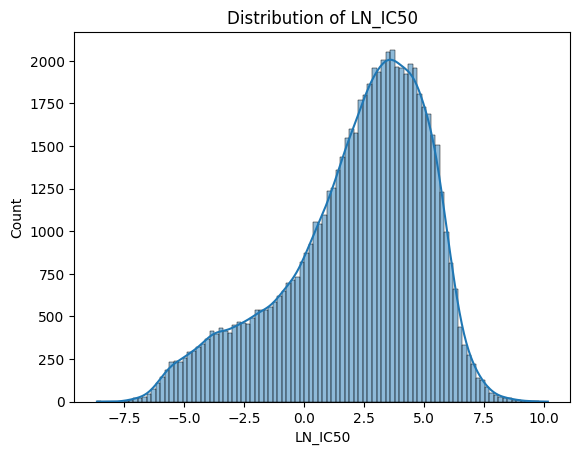

In [2]:
# Summary
print(data.info())
print(data.describe())

# Check missing values
print(data.isnull().sum())

# Target variable distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data['LN_IC50'], kde=True)
plt.title("Distribution of LN_IC50")


In [3]:
# Drop rows with missing target
data = data.dropna(subset=['LN_IC50'])

# Optionally drop rows with other missing values
data = data.dropna()

# Reset index
data.reset_index(drop=True, inplace=True)


In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
categorical_cols = ['CELL_LINE_NAME', 'SANGER_MODEL_ID', 'DRUG_NAME',
                    'PUTATIVE_TARGET', 'PATHWAY_NAME']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ['MIN_CONC', 'MAX_CONC', 'AUC', 'RMSE', 'Z_SCORE']
data[numeric_features] = scaler.fit_transform(data[numeric_features])


In [6]:
from sklearn.model_selection import train_test_split

X = data.drop(['LN_IC50', 'DATASET', 'WEBRELEASE', 'NLME_RESULT_ID',
               'NLME_CURVE_ID', 'COSMIC_ID', 'TCGA_DESC', 'COMPANY_ID'], axis=1)
y = data['LN_IC50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}, R² Score: {r2:.4f}")


MSE: 0.0200, R² Score: 0.9978


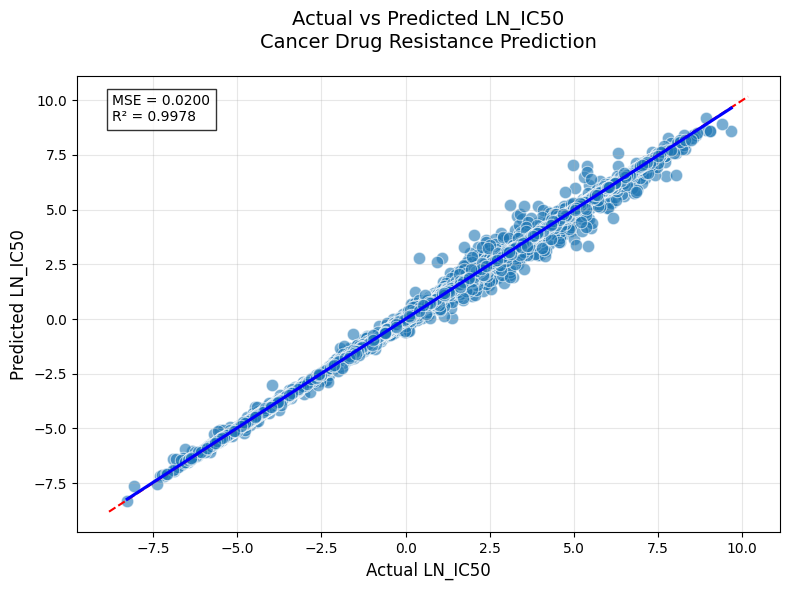

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=80)

# Add perfect prediction line (y=x)
max_val = max(max(y_test), max(y_pred)) + 0.5
min_val = min(min(y_test), min(y_pred)) - 0.5
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1.5)

# Add regression line
sns.regplot(x=y_test, y=y_pred, scatter=False, color='blue', ci=None)

# Add metrics to plot
plt.text(0.05, 0.9, f'MSE = {0.0200:.4f}\nR² = {0.9978:.4f}',
         transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Actual LN_IC50", fontsize=12)
plt.ylabel("Predicted LN_IC50", fontsize=12)
plt.title("Actual vs Predicted LN_IC50\nCancer Drug Resistance Prediction", fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

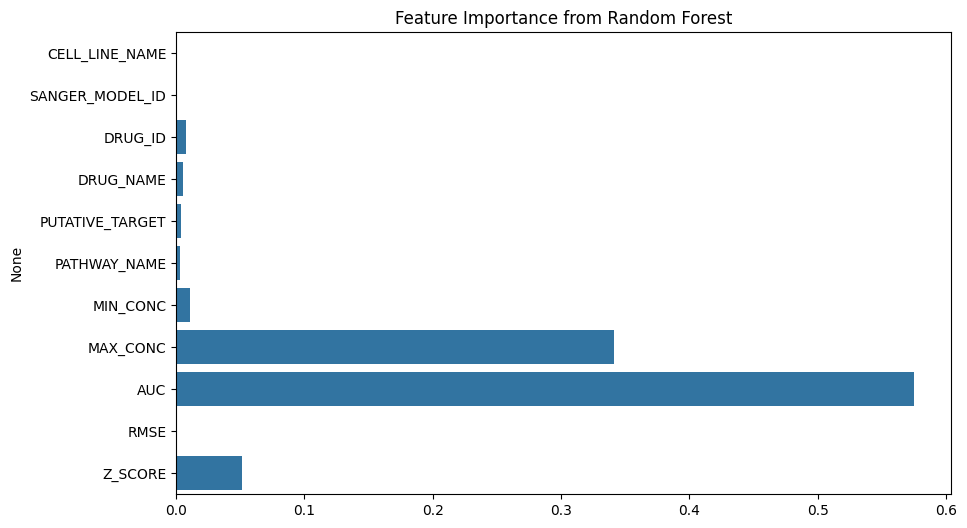

In [9]:
# Check basic statistics
print(f"Predicted min: {min(y_pred)}, max: {max(y_pred)}")
print(f"Actual min: {min(y_test)}, max: {max(y_test)}")importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance from Random Forest")
plt.show()


In [11]:
# Check basic statistics
print(f"Predicted min: {min(y_pred)}, max: {max(y_pred)}")
print(f"Actual min: {min(y_test)}, max: {max(y_test)}")

Predicted min: -8.307989350000012, max: 9.187637619999997
Actual min: -8.267077, max: 9.671139


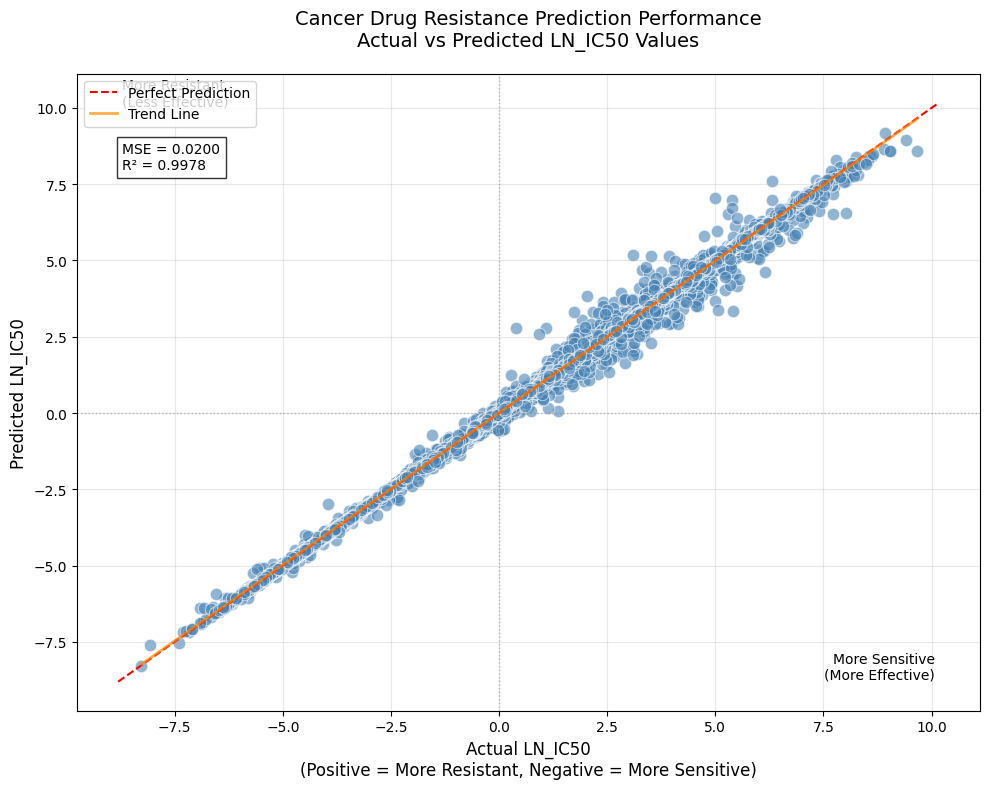

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10,8))
ax = sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=80, color='steelblue')

# Perfect prediction line (y=x)
max_val = max(max(y_test), max(y_pred)) + 0.5
min_val = min(min(y_test), min(y_pred)) - 0.5
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1.5, label='Perfect Prediction')

# Regression line
sns.regplot(x=y_test, y=y_pred, scatter=False, color='darkorange',
            line_kws={'lw':2, 'alpha':0.7}, label='Trend Line')

# Biological reference lines
plt.axhline(0, color='gray', linestyle=':', lw=1, alpha=0.5)
plt.axvline(0, color='gray', linestyle=':', lw=1, alpha=0.5)

# Quadrant annotations
plt.text(0.05, 0.95, "More Resistant\n(Less Effective)", transform=ax.transAxes, ha='left')
plt.text(0.95, 0.05, "More Sensitive\n(More Effective)", transform=ax.transAxes, ha='right')

# Metrics and labels
plt.text(0.05, 0.85, f'MSE = {0.0200:.4f}\nR² = {0.9978:.4f}',
         transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel("Actual LN_IC50\n(Positive = More Resistant, Negative = More Sensitive)", fontsize=12)
plt.ylabel("Predicted LN_IC50", fontsize=12)
plt.title("Cancer Drug Resistance Prediction Performance\nActual vs Predicted LN_IC50 Values", fontsize=14, pad=20)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

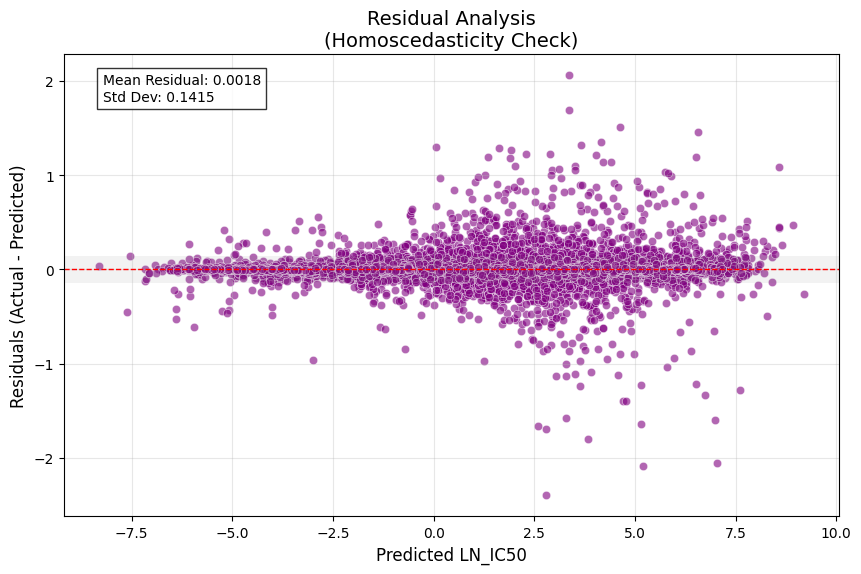

In [13]:
plt.figure(figsize=(10,6))
residuals = y_test - y_pred
ax = sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='purple')
plt.axhline(0, color='red', linestyle='--', lw=1)

# Highlight ±1 standard deviation
std_dev = np.std(residuals)
plt.axhspan(-std_dev, std_dev, facecolor='gray', alpha=0.1)

plt.xlabel("Predicted LN_IC50", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.title("Residual Analysis\n(Homoscedasticity Check)", fontsize=14)
plt.grid(True, alpha=0.3)

# Annotate error stats
plt.text(0.05, 0.9, f"Mean Residual: {np.mean(residuals):.4f}\nStd Dev: {std_dev:.4f}",
         transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
plt.show()

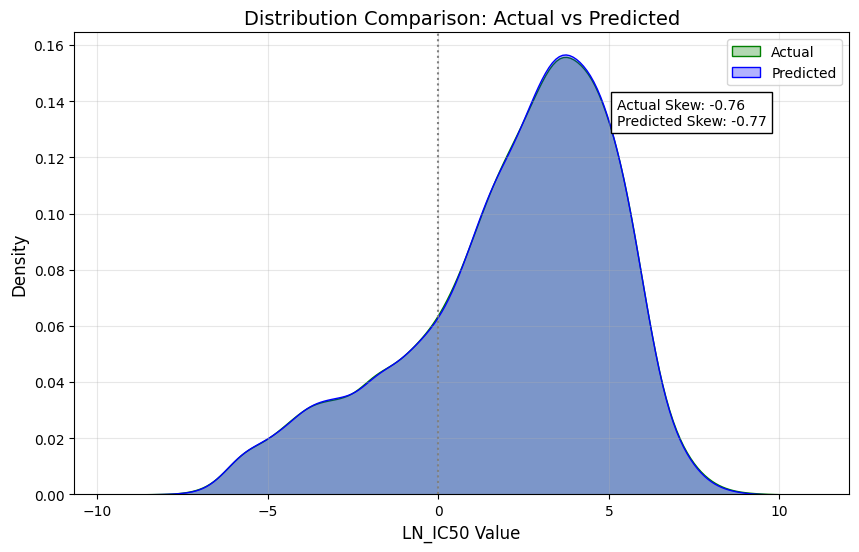

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew # Import the skew function

plt.figure(figsize=(10,6))
sns.kdeplot(y_test, label='Actual', fill=True, alpha=0.3, color='green')
sns.kdeplot(y_pred, label='Predicted', fill=True, alpha=0.3, color='blue')
plt.axvline(0, color='gray', linestyle=':')

plt.xlabel("LN_IC50 Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Distribution Comparison: Actual vs Predicted", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Statistical annotations
# Get current axes using plt.gca() since 'ax' was not defined earlier
ax = plt.gca()
plt.text(0.7, 0.8, f"Actual Skew: {skew(y_test):.2f}\nPredicted Skew: {skew(y_pred):.2f}",
         transform=ax.transAxes, bbox=dict(facecolor='white'))
plt.show()

<ipython-input-19-4cfa84ba5ee9>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df.head(20), x='Class', y='MSE', ax=ax1, palette='viridis')
<ipython-input-19-4cfa84ba5ee9>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df.head(20), x='Class', y='R2', ax=ax2, palette='viridis')


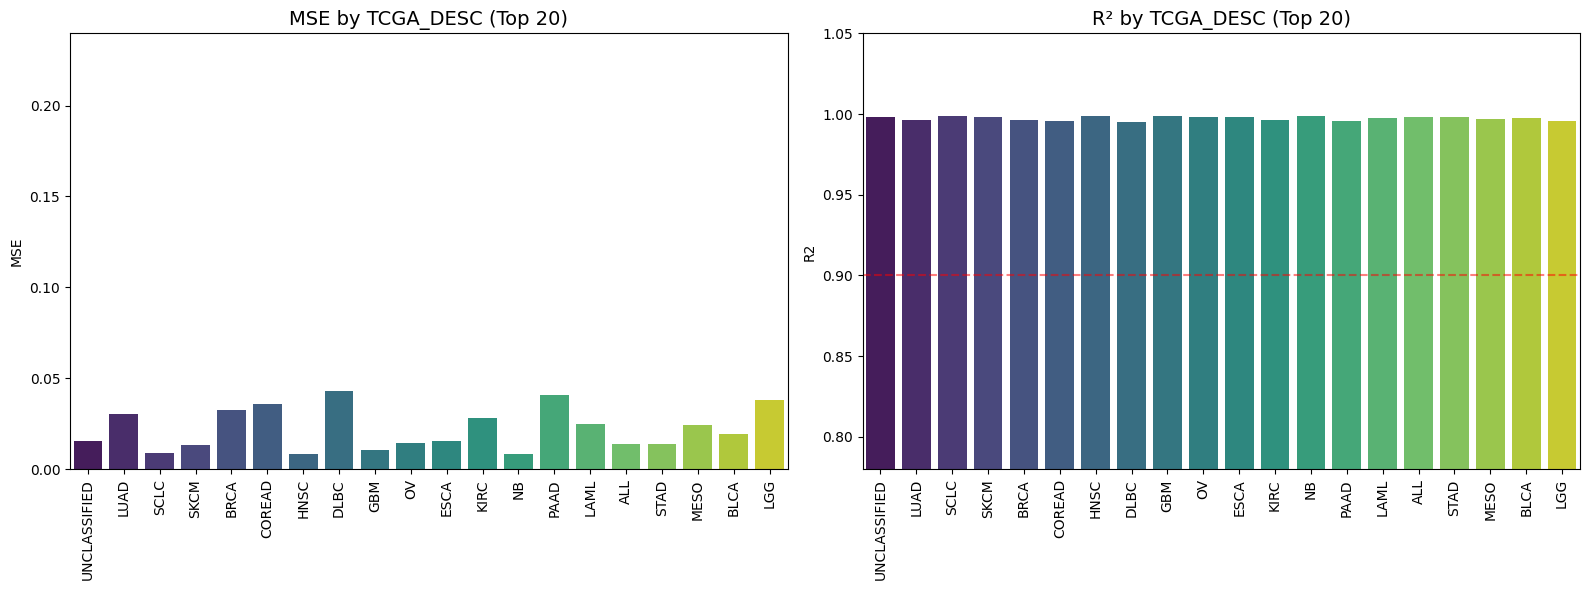

<ipython-input-19-4cfa84ba5ee9>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df.head(20), x='Class', y='MSE', ax=ax1, palette='viridis')
<ipython-input-19-4cfa84ba5ee9>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df.head(20), x='Class', y='R2', ax=ax2, palette='viridis')


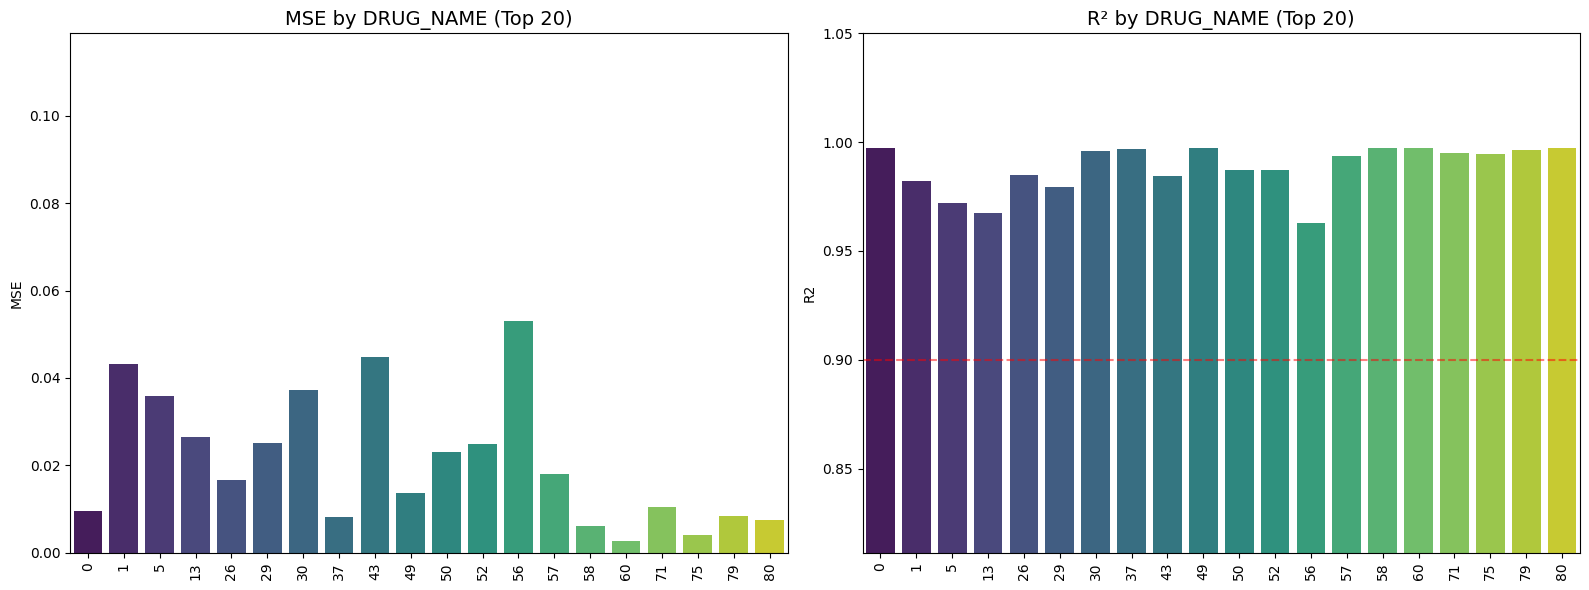

<ipython-input-19-4cfa84ba5ee9>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df.head(20), x='Class', y='MSE', ax=ax1, palette='viridis')
<ipython-input-19-4cfa84ba5ee9>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df.head(20), x='Class', y='R2', ax=ax2, palette='viridis')


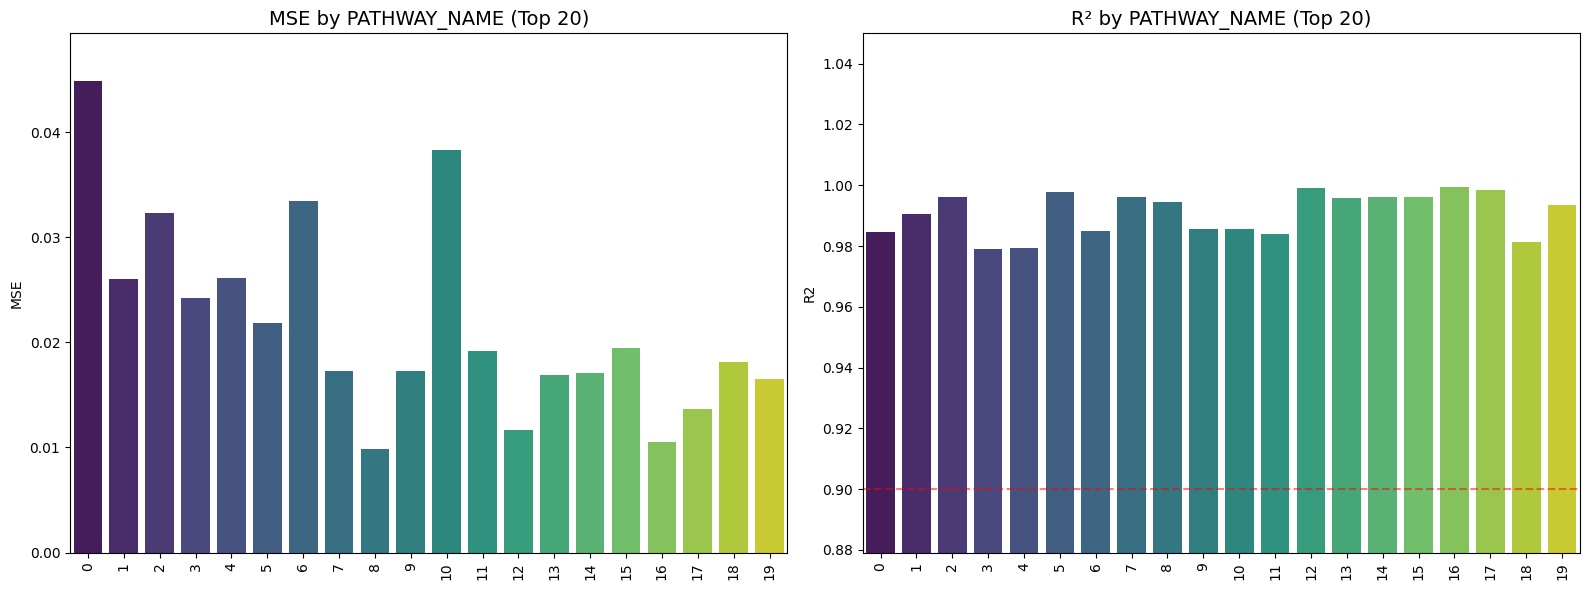

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def plot_stratified_performance(df, y_test, y_pred, stratify_col):
    # Ensure that the stratify column has the same indices as y_test and y_pred
    df_strat = df.loc[y_test.index]  # Match the index of df with y_test

    # Filter out null values in the stratification column
    valid_mask = df_strat[stratify_col].notnull()

    # Apply the mask to both the dataframe and the predictions
    df_strat = df_strat[valid_mask]
    y_test_strat = y_test[valid_mask]
    y_pred_strat = y_pred[valid_mask]

    # Calculate metrics per category
    classes = df_strat[stratify_col].unique()
    metrics = []

    for c in classes:
        mask = df_strat[stratify_col] == c
        if sum(mask) > 10:  # Only include categories with >10 samples
            mse = mean_squared_error(y_test_strat[mask], y_pred_strat[mask])
            r2 = r2_score(y_test_strat[mask], y_pred_strat[mask])
            metrics.append({
                'Class': c,
                'MSE': mse,
                'R2': r2,
                'Count': sum(mask)
            })

    metrics_df = pd.DataFrame(metrics).sort_values('Count', ascending=False)

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # MSE Plot - Top 20 categories only for clarity
    sns.barplot(data=metrics_df.head(20), x='Class', y='MSE', ax=ax1, palette='viridis')
    ax1.set_title(f"MSE by {stratify_col} (Top 20)", fontsize=14)
    ax1.tick_params(axis='x', rotation=90)
    ax1.set_ylim(0, metrics_df['MSE'].max()*1.1)
    ax1.set_xlabel("")

    # R² Plot - Top 20 categories
    sns.barplot(data=metrics_df.head(20), x='Class', y='R2', ax=ax2, palette='viridis')
    ax2.set_title(f"R² by {stratify_col} (Top 20)", fontsize=14)
    ax2.tick_params(axis='x', rotation=90)
    ax2.axhline(0.9, color='red', linestyle='--', alpha=0.5)
    ax2.set_ylim(metrics_df['R2'].min()-0.1, 1.05)
    ax2.set_xlabel("")

    plt.tight_layout()
    plt.show()

    return metrics_df

# Analyze by cancer type (TCGA_DESC)
tcga_metrics = plot_stratified_performance(data, y_test, y_pred, 'TCGA_DESC')

# Analyze by drug class (DRUG_NAME)
drug_metrics = plot_stratified_performance(data, y_test, y_pred, 'DRUG_NAME')

# Analyze by pathway (PATHWAY_NAME) - if available
if 'PATHWAY_NAME' in data.columns:
    pathway_metrics = plot_stratified_performance(data, y_test, y_pred, 'PATHWAY_NAME')


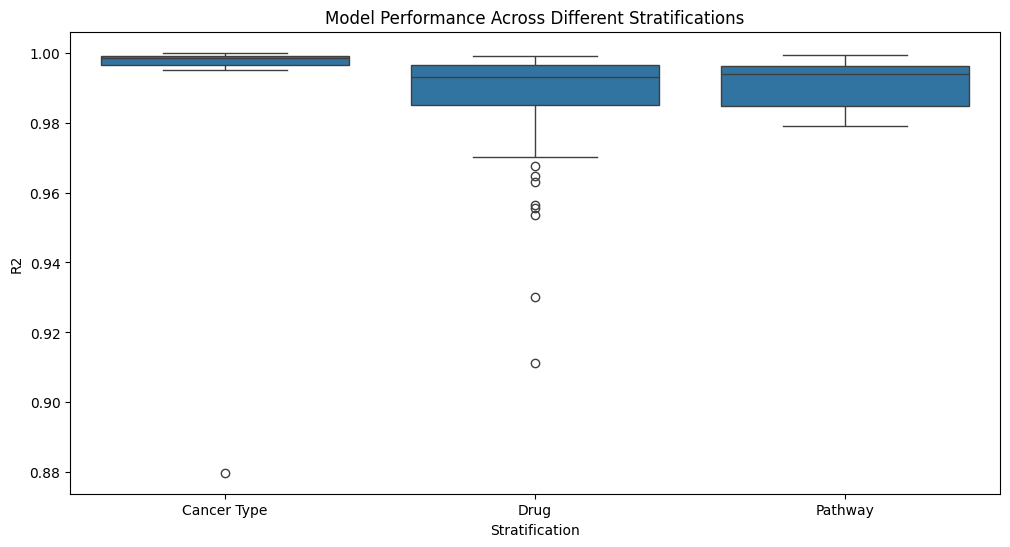

In [20]:

# Combined metric comparison
all_metrics = pd.concat([
    tcga_metrics.assign(Stratification='Cancer Type'),
    drug_metrics.assign(Stratification='Drug'),
    pathway_metrics.assign(Stratification='Pathway')
])

plt.figure(figsize=(12,6))
sns.boxplot(data=all_metrics, x='Stratification', y='R2')
plt.title("Model Performance Across Different Stratifications")
plt.show()
